A Structured Preprocessing Framework for 8-channel EMG/EEG Upper Limb Gesture Data: From Thalmic Labs Myo Armband and OpenBCI Raw Recordings to Curated CSV Datasets (Mendeley DOI:10.17632/m6t78vngbt.1)

from data: https://data.mendeley.com/datasets/m6t78vngbt/1

Final data processed files: EMG-Data.csv + EEG-Data.csv

In [2]:
import os
import re
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# Path configuration
DATA_ROOT = "data"
EMG_SOURCE = os.path.join(DATA_ROOT, "emg_subjects_csv_data")
EEG_SOURCE = os.path.join(DATA_ROOT, "eeg_subjects_csv_data")
OUTPUT_DIR = os.path.join(DATA_ROOT, "processed")
EMG_OUTPUT = os.path.join(OUTPUT_DIR, "EMG-data.csv")
EEG_OUTPUT = os.path.join(OUTPUT_DIR, "EEG-data.csv")

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)



Using device: cuda


EMG/EEG Data Inspection - Random File Selection, Full-Signal Plotting, and Temporal Validation


EMG File Analysis: S1_R6_G7.csv
Raw Shape: (1586, 8) | Columns: ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4', 'Channel_5', 'Channel_6', 'Channel_7', 'Channel_8']


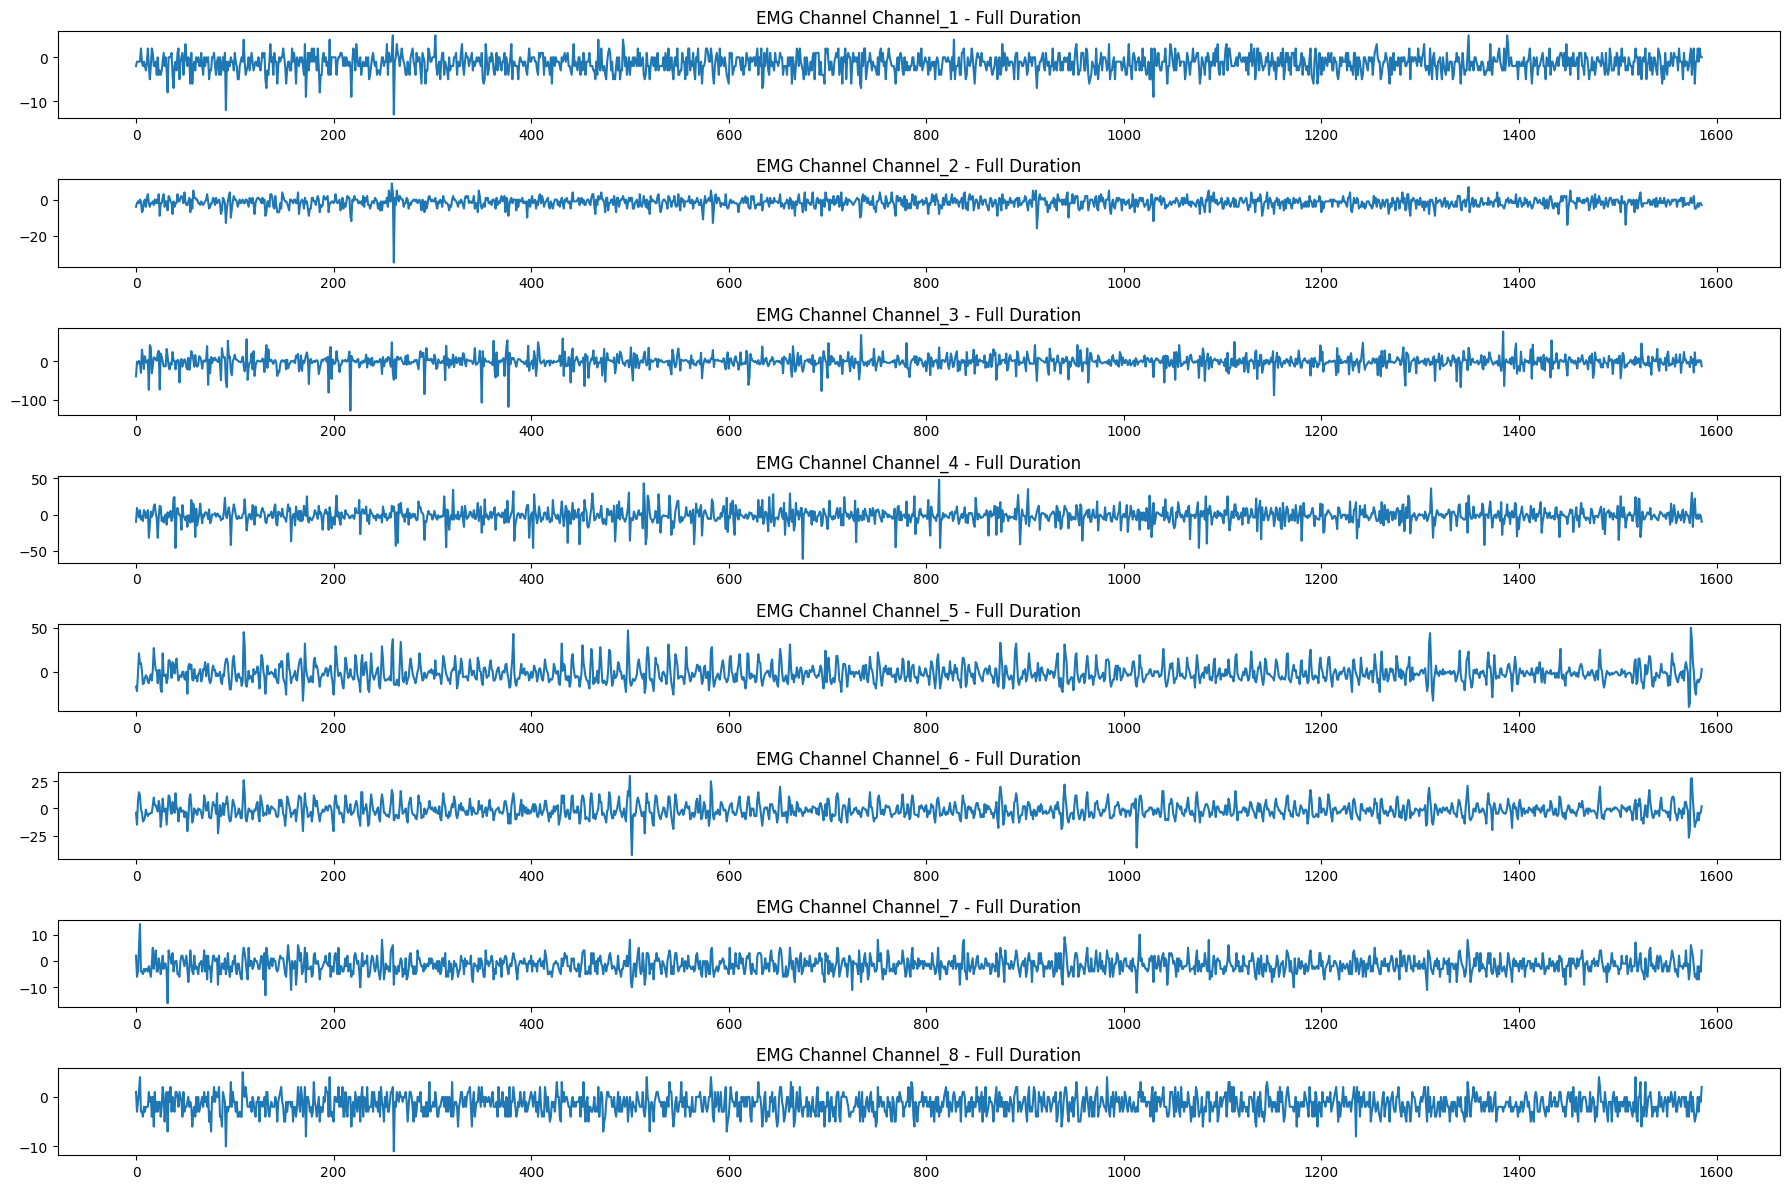


EEG File Analysis: S1_R2_G4.csv
Raw Shape: (8, 1349) (Channels x Timepoints)
First 3 Channel Samples:
               0              1              2              3              4
1   21571.333298   21392.496990   21317.685702   21489.928244   21591.181647
2   17658.839245   17505.863906   17193.163001   17308.475650   17603.652788
3 -132934.809677 -131699.205243 -133848.236066 -135158.137698 -133065.008588


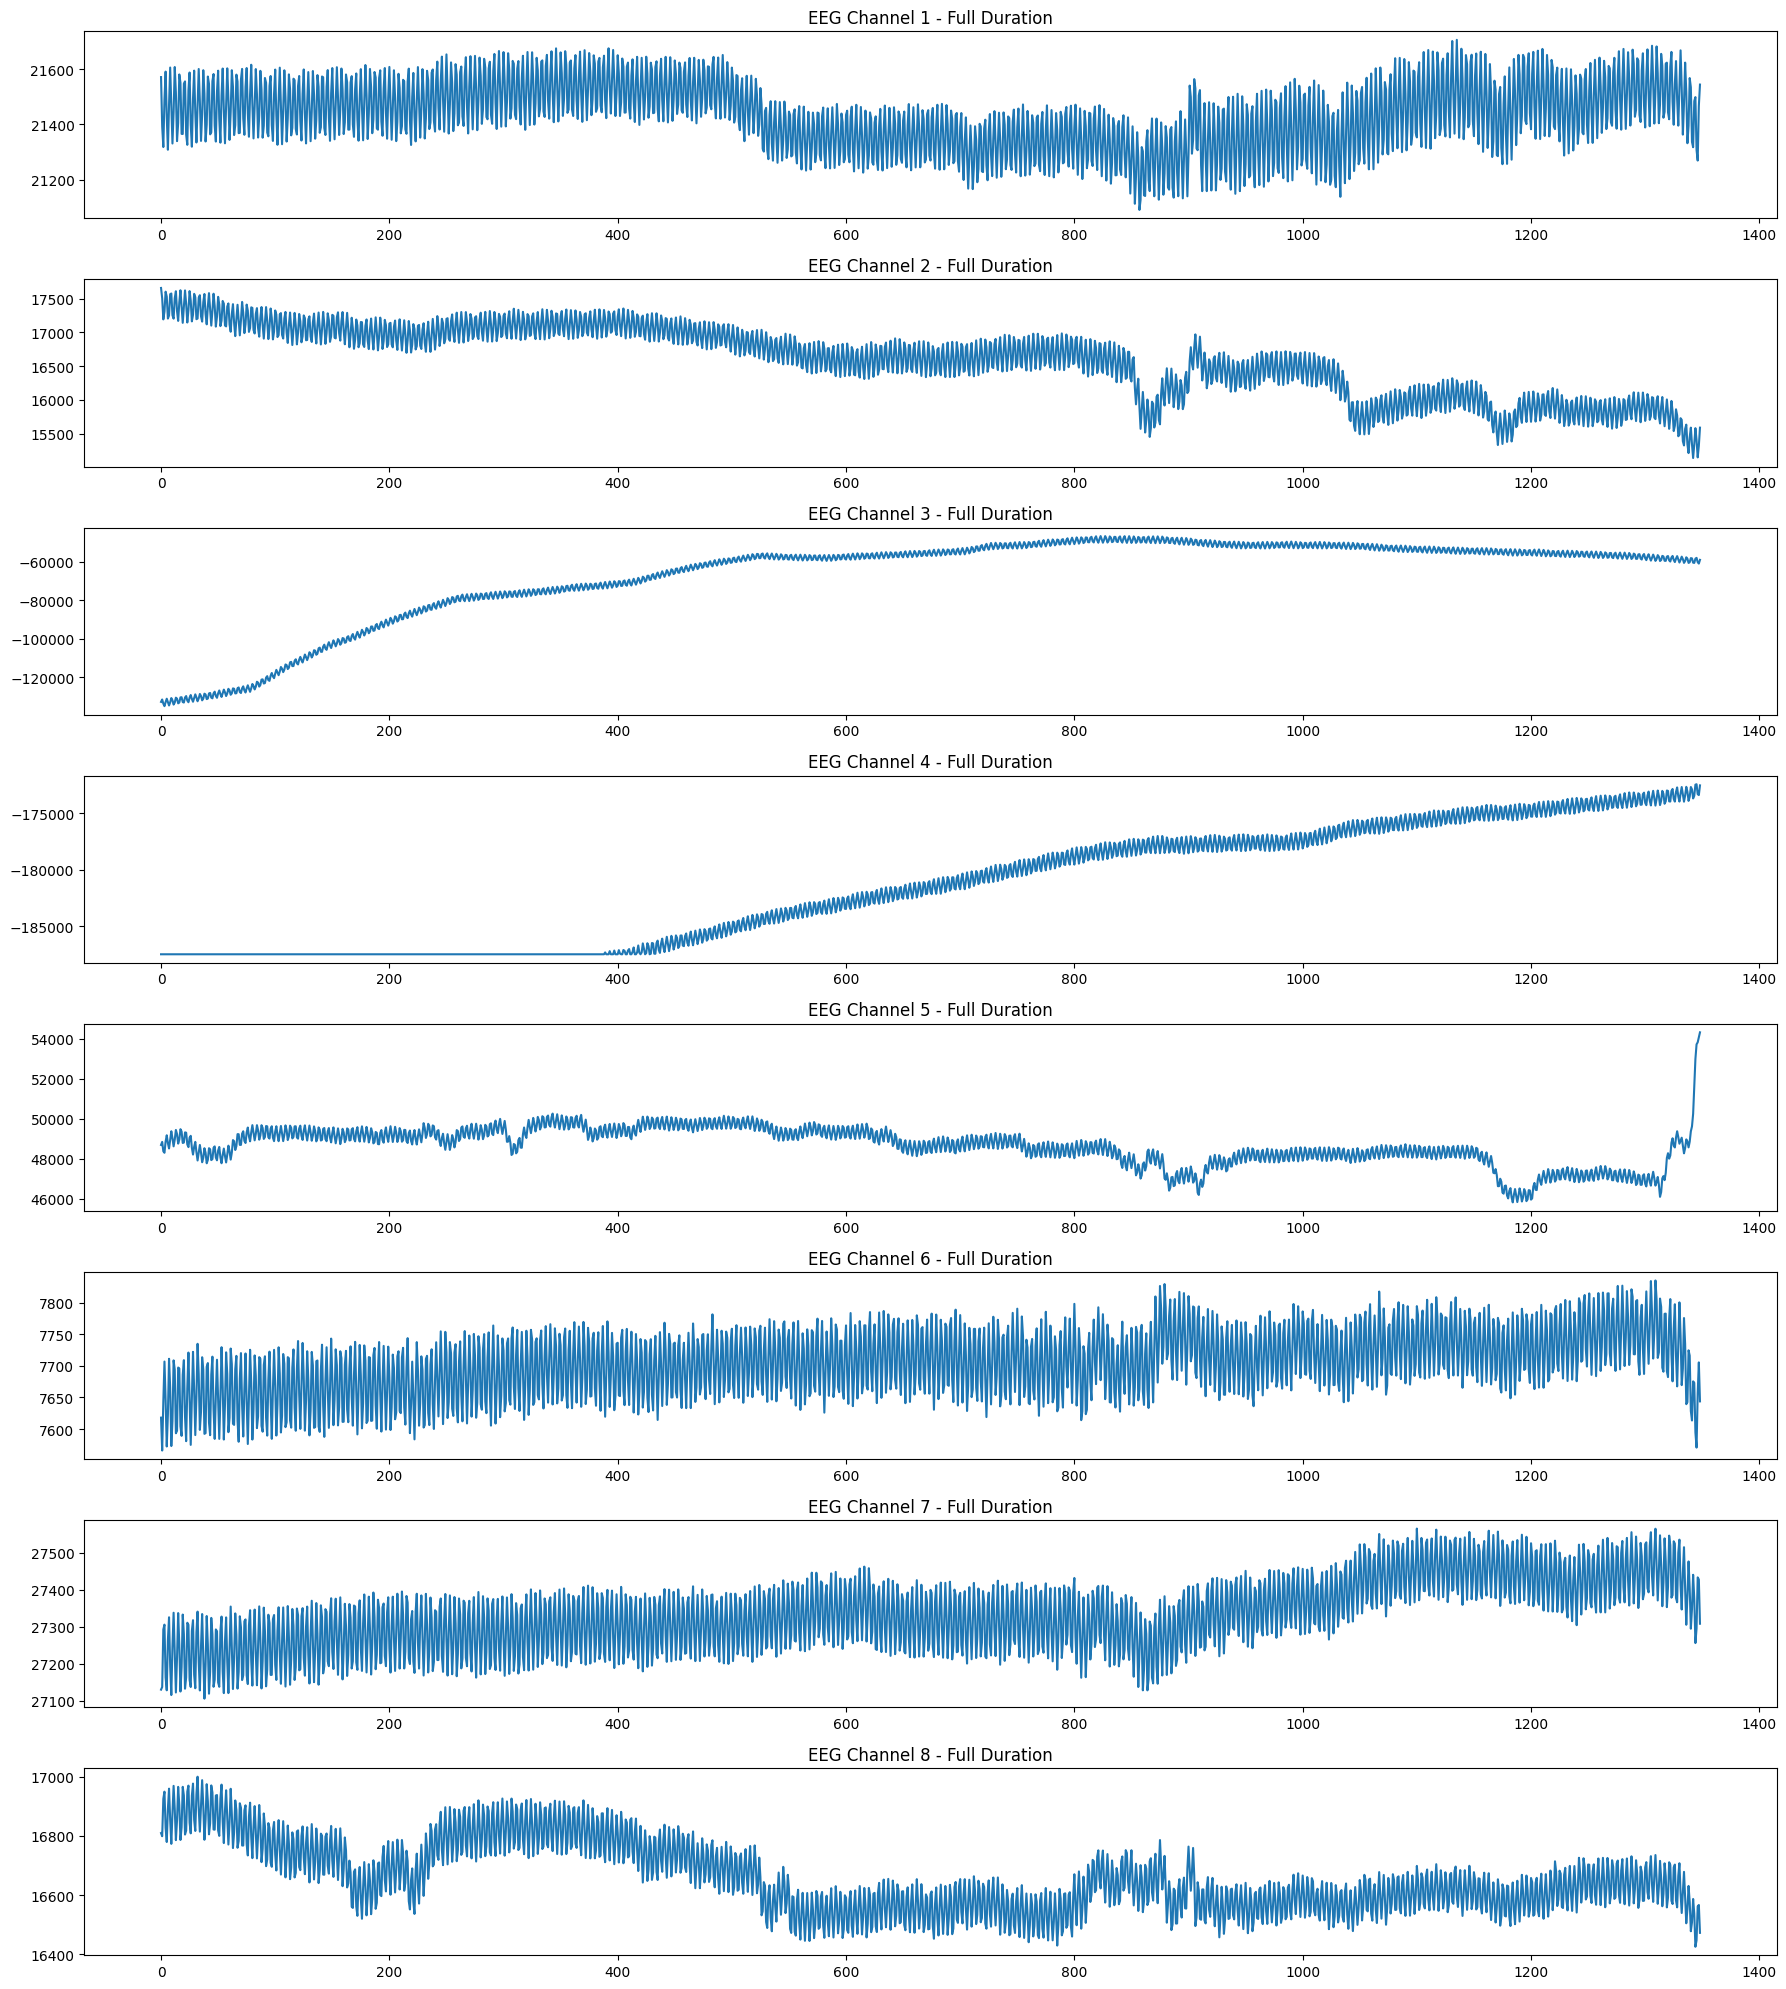


Time Axis Verification:
Start: 0.0ms, End: 1348.0ms
Sample Interval: 1.00ms


In [3]:

def get_random_file(directory):
    """Get random data file from specified directory"""
    for root, dirs, files in os.walk(directory):
        if files:
            return os.path.join(root, np.random.choice(files))
    raise FileNotFoundError(f"No files found in {directory}")

def inspect_random_files():
    """Analyze random EMG/EEG files showing full channel/timepoint views"""
    # Random file selection
    emg_file = get_random_file(EMG_SOURCE)
    eeg_file = get_random_file(EEG_SOURCE)
    
    # EMG Inspection
    print("\n" + "="*50)
    print("EMG File Analysis:", os.path.basename(emg_file))
    emg_df = pd.read_csv(emg_file)
    print(f"Raw Shape: {emg_df.shape} | Columns: {emg_df.columns.tolist()}")
    
    # Plot all EMG channels
    plt.figure(figsize=(18, 12))
    for i, col in enumerate([c for c in emg_df.columns if not c.isnumeric()], 1):
        plt.subplot(len(emg_df.columns), 1, i)
        plt.plot(emg_df[col])
        plt.title(f"EMG Channel {col} - Full Duration")
    plt.tight_layout()
    plt.show()

    # EEG Inspection
    print("\n" + "="*50)
    print("EEG File Analysis:", os.path.basename(eeg_file))
    eeg_raw = pd.read_csv(eeg_file, header=None)
    timestamps = eeg_raw.iloc[0, :]  # Save first row timestamps
    channels = eeg_raw.iloc[1:, :]   # Actual EEG channels
    
    print(f"Raw Shape: {channels.shape} (Channels x Timepoints)")
    print("First 3 Channel Samples:")
    print(channels.iloc[:3, :5])
    
    # Process EEG data
    eeg_df = channels.T
    eeg_df.columns = [f'Channel_{i+1}' for i in range(channels.shape[0])]
    
    # Plot all EEG channels
    plt.figure(figsize=(18, 20))
    for i in range(eeg_df.shape[1]):
        plt.subplot(eeg_df.shape[1], 1, i+1)
        plt.plot(eeg_df.iloc[:, i])
        plt.title(f"EEG Channel {i+1} - Full Duration")
    plt.tight_layout()
    plt.show()

    # Timeline verification
    print("\nTime Axis Verification:")
    print(f"Start: {timestamps.min():.1f}ms, End: {timestamps.max():.1f}ms")
    print(f"Sample Interval: {(timestamps[1] - timestamps[0]):.2f}ms")

# Execute inspection
inspect_random_files()


Data Processing 

In [4]:

def parse_filename(filename):
    """Extract subject, repetition, and gesture from filename"""
    match = re.match(r"S(\d+)_R(\d+)_G(\d+)\.csv", filename)
    if match:
        return tuple(map(int, match.groups()))
    return (None, None, None)

def process_emg_data():
    """Process and aggregate EMG data with validation"""
    all_dfs = []
    file_list = []

    # File collection
    for subject_folder in tqdm(os.listdir(EMG_SOURCE), desc="Scanning EMG folders"):
        subject_path = os.path.join(EMG_SOURCE, subject_folder)
        if os.path.isdir(subject_path):
            for fname in os.listdir(subject_path):
                if fname.endswith(".csv"):
                    sub_id, rep, gest = parse_filename(fname)
                    if sub_id is not None:
                        file_list.append((subject_path, fname, sub_id, rep, gest))

    # Data processing
    for subject_path, fname, sub_id, rep, gest in tqdm(file_list, desc="Processing EMG files"):
        try:
            file_path = os.path.join(subject_path, fname)
            df = pd.read_csv(file_path)
            
            if df.shape[1] < 8:
                raise ValueError(f"Unexpected EMG format in {fname}")
                
            df["subject"] = sub_id
            df["repetition"] = rep
            df["gesture"] = gest
            all_dfs.append(df)
            
        except Exception as e:
            print(f"Error processing {fname}: {e}")

    # Save and convert
    if all_dfs:
        combined_df = pd.concat(all_dfs, ignore_index=True)
        combined_df.to_csv(EMG_OUTPUT, index=False)
        
        features = torch.tensor(
            combined_df.drop(columns=["subject", "gesture", "repetition"]).values,
            dtype=torch.float32
        ).to(device)
        
        labels = torch.tensor(
            combined_df["gesture"].values,
            dtype=torch.long
        ).to(device)
        
        return features, labels
    
    raise ValueError("No valid EMG data processed")


def process_eeg_data():
    """Process and aggregate EEG data with timestamp handling"""
    all_dfs = []
    file_list = []

    # File collection
    for subject_folder in tqdm(os.listdir(EEG_SOURCE), desc="Scanning EEG folders"):
        subject_path = os.path.join(EEG_SOURCE, subject_folder)
        if os.path.isdir(subject_path):
            for fname in os.listdir(subject_path):
                if fname.endswith(".csv"):
                    sub_id, rep, gest = parse_filename(fname)
                    if sub_id is not None:
                        file_list.append((subject_path, fname, sub_id, rep, gest))

    # Data processing
    for subject_path, fname, sub_id, rep, gest in tqdm(file_list, desc="Processing EEG files"):
        try:
            file_path = os.path.join(subject_path, fname)
            raw_data = pd.read_csv(file_path, header=None)
            
            channel_data = raw_data.iloc[1:, :]
            df = channel_data.T
            df.columns = [f"Channel_{i+1}" for i in range(df.shape[1])]
            
            df = df.assign(
                subject=sub_id,
                repetition=rep,
                gesture=gest
            )
            
            all_dfs.append(df)
            
        except Exception as e:
            print(f"Error processing {fname}: {e}")

    # Save and convert
    if all_dfs:
        combined_df = pd.concat(all_dfs, ignore_index=True)
        combined_df.to_csv(EEG_OUTPUT, index=False)
        
        features = torch.tensor(
            combined_df.filter(like='Channel').values,
            dtype=torch.float32
        ).to(device)
        
        labels = torch.tensor(
            combined_df['gesture'].values,
            dtype=torch.long
        ).to(device)
        
        return features, labels
    
    raise ValueError("No valid EEG data processed")


Execute Data Processing

In [5]:

# Clean previous files
print("Cleaning previous output files...")
for fpath in [EMG_OUTPUT, EEG_OUTPUT]:
    try:
        os.remove(fpath)
        print(f"Removed old file: {fpath}")
    except FileNotFoundError:
        continue

# Process data
emg_features, emg_labels = process_emg_data()
eeg_features, eeg_labels = process_eeg_data()


Cleaning previous output files...
Removed old file: data\processed\EMG-data.csv
Removed old file: data\processed\EEG-data.csv


Processing EEG files: 100%|██████████| 420/420 [00:14<00:00, 29.04it/s]


In [6]:

# Check dimensions
print(f"\nEEG Features: {eeg_features.shape}, Labels: {eeg_labels.shape}")
print(f"EMG Features: {emg_features.shape}, Labels: {emg_labels.shape}")



EEG Features: torch.Size([564641, 8]), Labels: torch.Size([564641])
EMG Features: torch.Size([664666, 8]), Labels: torch.Size([664666])


EEG Processing Validation

data/eeg_subjects_csv_data/subject_1/S1_R2_G4.csv
Raw EEG File Structure:
Filename: S1_R2_G4.csv
Shape: (9, 1349) (rows=timestamps+channels, columns=timestamps)

Timestamp row (first 5 values):
[0. 1. 2. 3. 4.]

First 3 EEG channels (rows 1-3) and first 5 timepoints:
               0              1              2              3              4
1   21571.333298   21392.496990   21317.685702   21489.928244   21591.181647
2   17658.839245   17505.863906   17193.163001   17308.475650   17603.652788
3 -132934.809677 -131699.205243 -133848.236066 -135158.137698 -133065.008588

Processed EEG Structure:
Shape: (1349, 11) (timepoints x channels+metadata)
First 3 timepoints and channels:
      Channel_1     Channel_2      Channel_3
0  21571.333298  17658.839245 -132934.809677
1  21392.496990  17505.863906 -131699.205243
2  21317.685702  17193.163001 -133848.236066

Data Integrity Check:
Mean Absolute Difference per Channel:
Channel 1: 0.000000
Channel 2: 0.000000
Channel 3: 0.000000
Channel 4: 0.

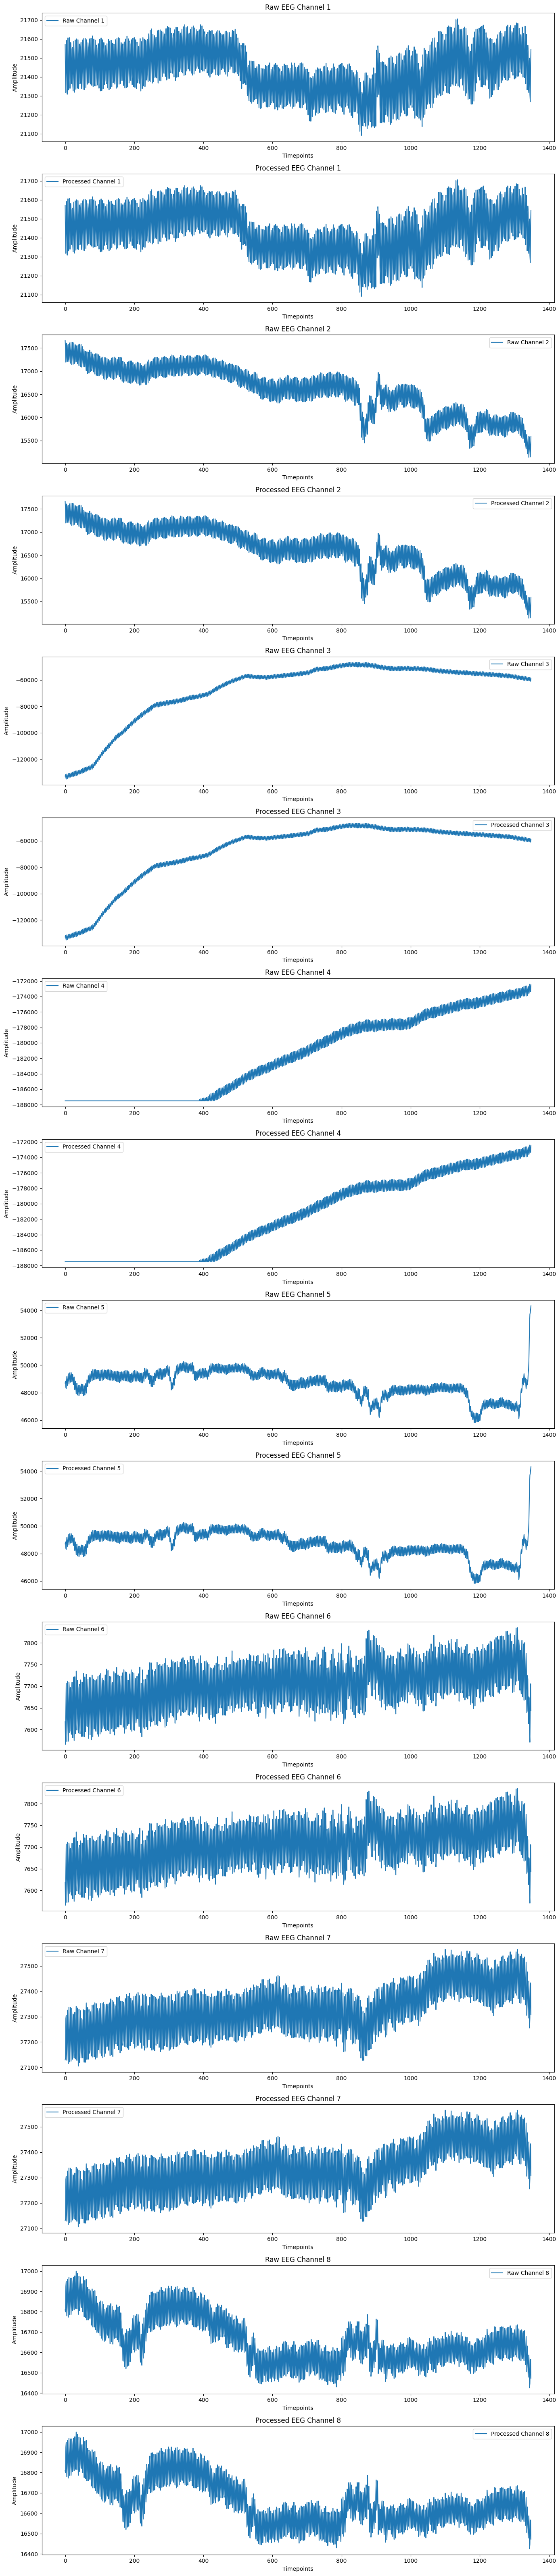

In [10]:

def validate_eeg_processing(sample_file=None):
    """Validate EEG processing with proper timestamp handling"""
    if not sample_file:
        for root, dirs, files in os.walk(EEG_SOURCE):
            if files:
                sample_file = os.path.join(root, files[5])
                break

    print(sample_file)
    raw_eeg = pd.read_csv(sample_file, header=None)
    print("Raw EEG File Structure:")
    print(f"Filename: {os.path.basename(sample_file)}")
    print(f"Shape: {raw_eeg.shape} (rows=timestamps+channels, columns=timestamps)")
    
    timestamps = raw_eeg.iloc[0, :]
    channels = raw_eeg.iloc[1:, :]
    
    print("\nTimestamp row (first 5 values):")
    print(timestamps[:5].values)
    print("\nFirst 3 EEG channels (rows 1-3) and first 5 timepoints:")
    print(channels.iloc[:3, :5])

    sub_id, rep, gest = parse_filename(os.path.basename(sample_file))
    processed_df = pd.read_csv(EEG_OUTPUT)
    processed_subset = processed_df[
        (processed_df['subject'] == sub_id) & 
        (processed_df['repetition'] == rep) &
        (processed_df['gesture'] == gest)
    ].reset_index(drop=True)

    print("\nProcessed EEG Structure:")
    print(f"Shape: {processed_subset.shape} (timepoints x channels+metadata)")
    print("First 3 timepoints and channels:")
    print(processed_subset.filter(like='Channel').iloc[:3, :3])

    raw_values = channels.values.astype(float)
    processed_values = processed_subset.filter(like='Channel').values.astype(float).T
    
    if raw_values.shape != processed_values.shape:
        print(f"\nWarning: Shape mismatch detected! Raw: {raw_values.shape}, Processed: {processed_values.shape}")
        return
    
    mismatch = np.mean(np.abs(raw_values - processed_values), axis=1)
    print("\nData Integrity Check:")
    print("Mean Absolute Difference per Channel:")
    for i, diff in enumerate(mismatch):
        print(f"Channel {i+1}: {diff:.6f}")

    # Plot each channel in a new row for raw and processed separately
    num_channels = raw_values.shape[0]
    fig, ax = plt.subplots(num_channels * 2, 1, figsize=(14, 4 * num_channels * 2))  # 2 plots per channel (raw + processed)

    if num_channels == 1:  # To handle the case where there's only one channel
        ax = [ax]

    for i in range(num_channels):
        # Plot Raw EEG Channel
        ax[i * 2].plot(raw_values[i, :], label=f'Raw Channel {i+1}')
        ax[i * 2].set_title(f"Raw EEG Channel {i+1}")
        ax[i * 2].set_xlabel('Timepoints')
        ax[i * 2].set_ylabel('Amplitude')
        ax[i * 2].legend()

        # Plot Processed EEG Channel
        ax[i * 2 + 1].plot(processed_values[i, :], label=f'Processed Channel {i+1}')
        ax[i * 2 + 1].set_title(f"Processed EEG Channel {i+1}")
        ax[i * 2 + 1].set_xlabel('Timepoints')
        ax[i * 2 + 1].set_ylabel('Amplitude')
        ax[i * 2 + 1].legend()

    plt.tight_layout()
    plt.show()

validate_eeg_processing("data/eeg_subjects_csv_data/subject_1/S1_R2_G4.csv")

data/emg_subjects_csv_data/subject_10/S10_R1_G1.csv
Raw EMG File Structure:
Filename: S10_R1_G1.csv
Shape: (1580, 8) (timepoints x channels)

First 3 EMG channels and first 5 timepoints:
   Channel_1  Channel_2  Channel_3
0         -9          1         -5
1          2         -1         -3
2         -2         -4          2
3         43          4         -5
4         -7         -7          0

Processed EMG Structure:
Shape: (1580, 11) (timepoints x channels+metadata)
First 3 timepoints and channels:
   Channel_1  Channel_2  Channel_3
0         -9          1         -5
1          2         -1         -3
2         -2         -4          2

Data Integrity Check:
Mean Absolute Difference per Channel:
Channel 1: 0.000000
Channel 2: 0.000000
Channel 3: 0.000000
Channel 4: 0.000000
Channel 5: 0.000000
Channel 6: 0.000000
Channel 7: 0.000000
Channel 8: 0.000000


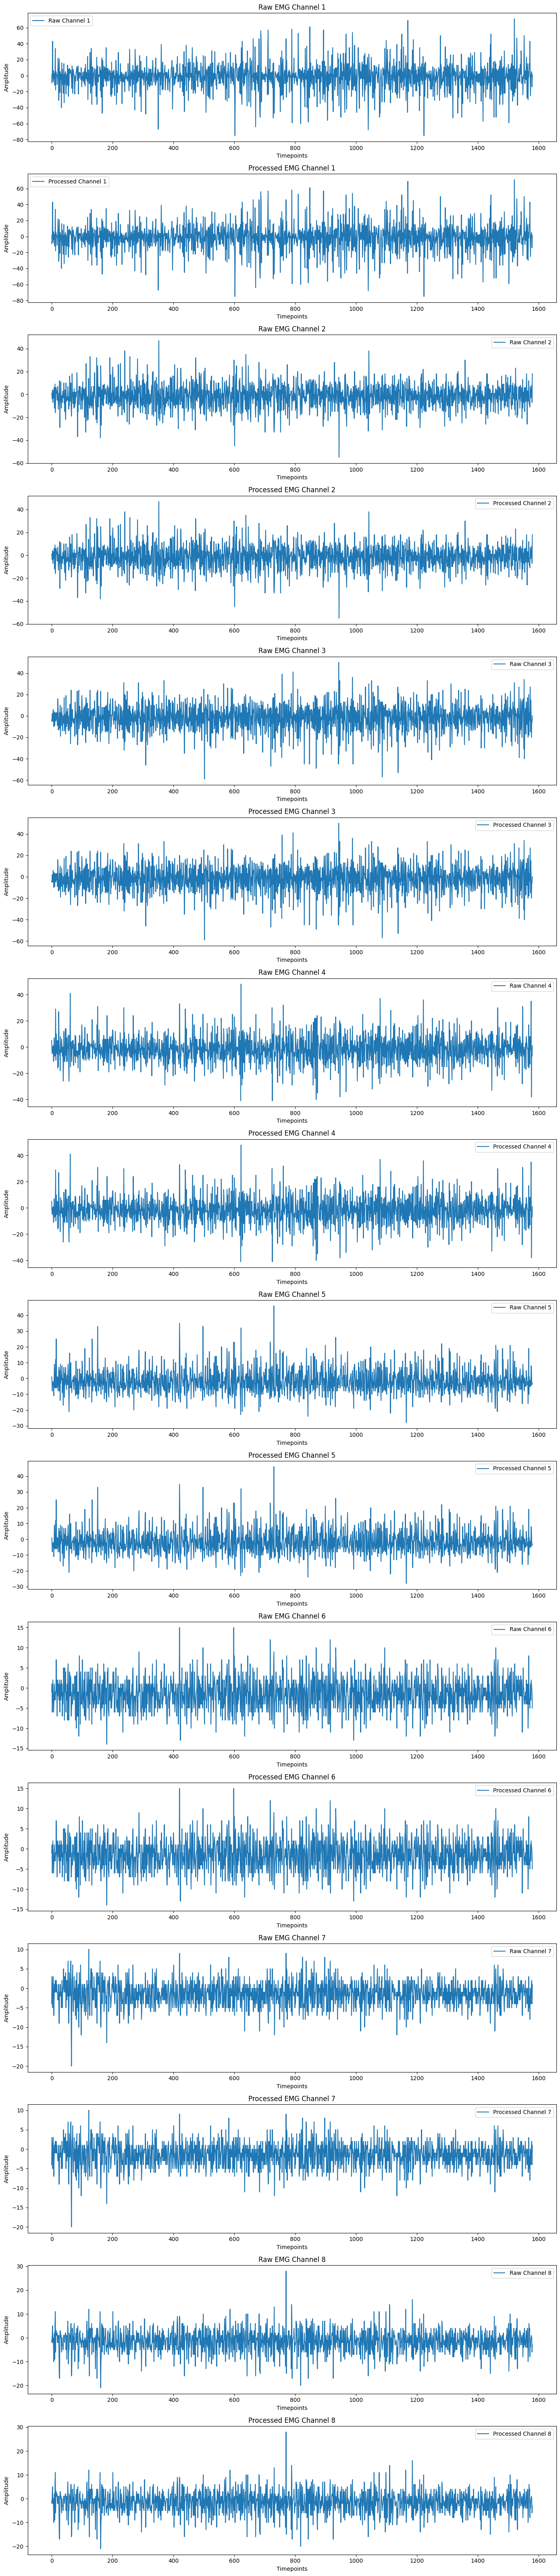

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

def validate_emg_processing(sample_file=None):
    """Validate EMG processing with proper timestamp handling"""
    if not sample_file:
        for root, dirs, files in os.walk(EMG_SOURCE):
            if files:
                sample_file = os.path.join(root, files[5])
                break

    print(sample_file)
    raw_emg = pd.read_csv(sample_file)
    print("Raw EMG File Structure:")
    print(f"Filename: {os.path.basename(sample_file)}")
    print(f"Shape: {raw_emg.shape} (timepoints x channels)")
    
    print("\nFirst 3 EMG channels and first 5 timepoints:")
    print(raw_emg.iloc[:5, :3])

    sub_id, rep, gest = parse_filename(os.path.basename(sample_file))
    processed_df = pd.read_csv(EMG_OUTPUT)
    processed_subset = processed_df[
        (processed_df['subject'] == sub_id) & 
        (processed_df['repetition'] == rep) &
        (processed_df['gesture'] == gest)
    ].reset_index(drop=True)

    print("\nProcessed EMG Structure:")
    print(f"Shape: {processed_subset.shape} (timepoints x channels+metadata)")
    print("First 3 timepoints and channels:")
    print(processed_subset.filter(like='Channel').iloc[:3, :3])

    raw_values = raw_emg.values.astype(float)
    processed_values = processed_subset.filter(like='Channel').values.astype(float)  # Fixed line

    if raw_values.shape != processed_values.shape:
        print(f"\nWarning: Shape mismatch detected! Raw: {raw_values.shape}, Processed: {processed_values.shape}")
        return
    
    mismatch = np.mean(np.abs(raw_values - processed_values), axis=0)
    print("\nData Integrity Check:")
    print("Mean Absolute Difference per Channel:")
    for i, diff in enumerate(mismatch):
        print(f"Channel {i+1}: {diff:.6f}")

    # Plot each channel separately in a new row
    num_channels = raw_values.shape[1]
    fig, ax = plt.subplots(num_channels * 2, 1, figsize=(14, 4 * num_channels * 2))

    if num_channels == 1:  # Handle single-channel case
        ax = [ax]

    for i in range(num_channels):
        # Plot Raw EMG Channel
        ax[i * 2].plot(raw_values[:, i], label=f'Raw Channel {i+1}')
        ax[i * 2].set_title(f"Raw EMG Channel {i+1}")
        ax[i * 2].set_xlabel('Timepoints')
        ax[i * 2].set_ylabel('Amplitude')
        ax[i * 2].legend()

        # Plot Processed EMG Channel
        ax[i * 2 + 1].plot(processed_values[:, i], label=f'Processed Channel {i+1}')
        ax[i * 2 + 1].set_title(f"Processed EMG Channel {i+1}")
        ax[i * 2 + 1].set_xlabel('Timepoints')
        ax[i * 2 + 1].set_ylabel('Amplitude')
        ax[i * 2 + 1].legend()

    plt.tight_layout()
    plt.show()

validate_emg_processing("data/emg_subjects_csv_data/subject_10/S10_R1_G1.csv")
